In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
filepath='./../data/data.csv'
df=pd.read_csv(filepath)

<p style="font-size:25px">In this notebook, I will be modeling for this project. </p>
<p style="font-size:16px;">My process for modeling in this project consists of the following:</p>
<ol>
    <li><b>Data Preperation</b></li>
    <dd>I split the data into my input and output variables. Then I create my train and test sets so that the model can be evaluated on unseen data.</dd>
    <li><b>Model Creation</b></li>
    <dd>I create 6 different models to see which one will perform the best.</dd>
    <li><b>Model Training and Prediction</b></li>
    <dd>I train the models then make predictions on the test set. I also calculate the residuals of each model.</dd>
    <li><b>Model Analysis</b></li>
    <dd>I look at the performance of the models to study how they react to unseen data</dd>  
    <li><b>Model Selection</b></li>
    <dd>I compare my models to see which one had the best performance.</dd> 
    <li><b>Feature Analysis</b></li>
    <dd>I study the best model to see which features are important for predicting home value.</dd> 
</ol>    

<p style="font-size:20px">Data Preperation</p>

In [2]:
df=df.drop(columns=df.isna().sum()[df.isna().sum()!=0].index)

In [3]:
from sklearn.model_selection import train_test_split
TARGET='SalePrice'
y=df[TARGET]
X=df.drop(columns=[TARGET])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<p style="font-size:20px">Model Creation</p>

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

In [6]:
model1=DummyRegressor(strategy="mean")
model2=KNeighborsRegressor(n_neighbors=2)
model3=KNeighborsRegressor(n_neighbors=8)
temp=len(X.columns)
model4=RandomForestRegressor(max_depth=int(temp*.1)+1, random_state=0)
model5=RandomForestRegressor(max_depth=int(temp*.4)+1, random_state=0)
model6=ElasticNet(random_state=0)

In [7]:
models=[model1,model2,model3,model4,model5,model6]

<p style="font-size:20px">Model Training and Prediction </p>

In [8]:
predictions={}
residuals={}
for model in models:
    model.fit(X_train, y_train)
    predictions[str(model)]=model.predict(X_test)
    residuals[str(model)]=y_test-predictions[str(model)]

<p style="font-size:20px">Model Analysis</p>

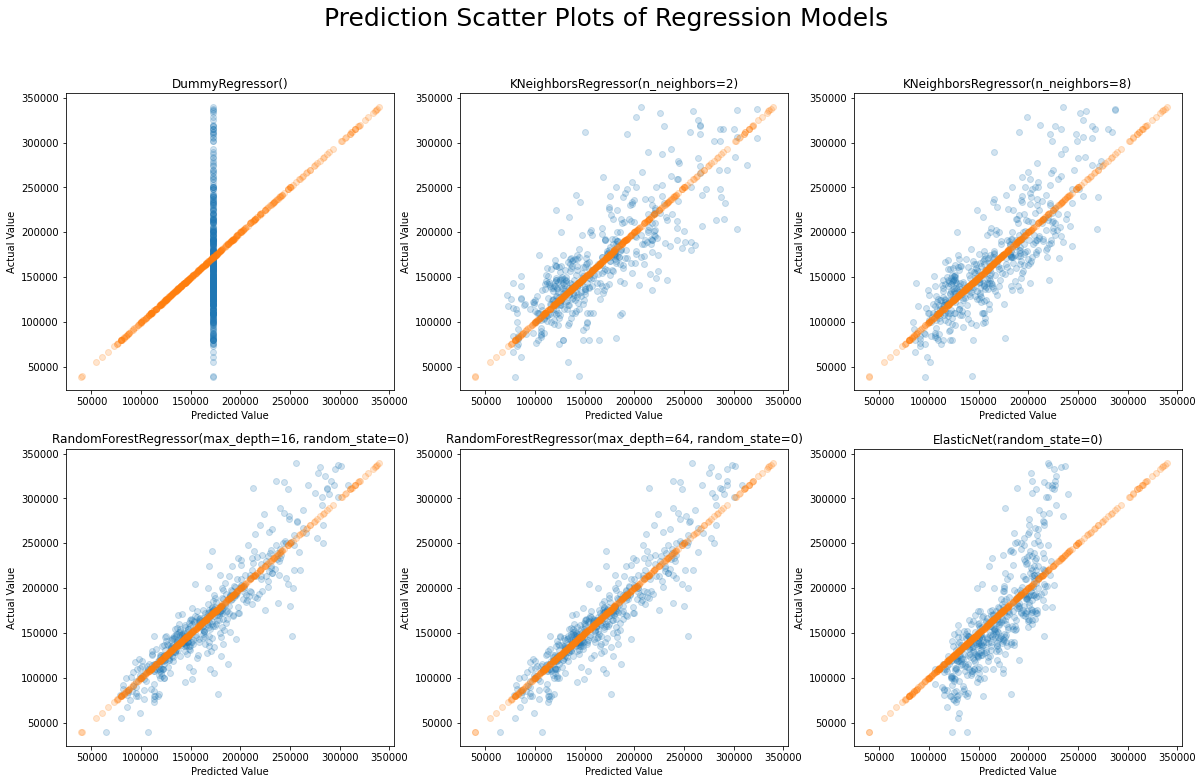

In [9]:
fig, ax = plt.subplots(2,3,figsize=(20,12))
fig.suptitle('Prediction Scatter Plots of Regression Models',fontsize=25)
mods=list(predictions.keys())
count=0
for i in range(2):
    for j in range(3):
        temp=mods[count]
        ax[i][j].set_title(temp)
        ax[i][j].set_xlabel('Predicted Value')
        ax[i][j].set_ylabel('Actual Value')
        ax[i][j].scatter(predictions[temp],y_test,alpha=0.2)
        ax[i][j].scatter(y_test,y_test,alpha=0.2)
        count+=1

In the graphs above, I plot the predicted sale prices agaisnt the actual sale prices for each model. This helps us see any patterns in the predictions that our models make. The goal is for the blue points to be as close to the orange points as possible. Based on these graphs, we can already see that the ElasticNet and Dummy Regressor aren't the best performing models.

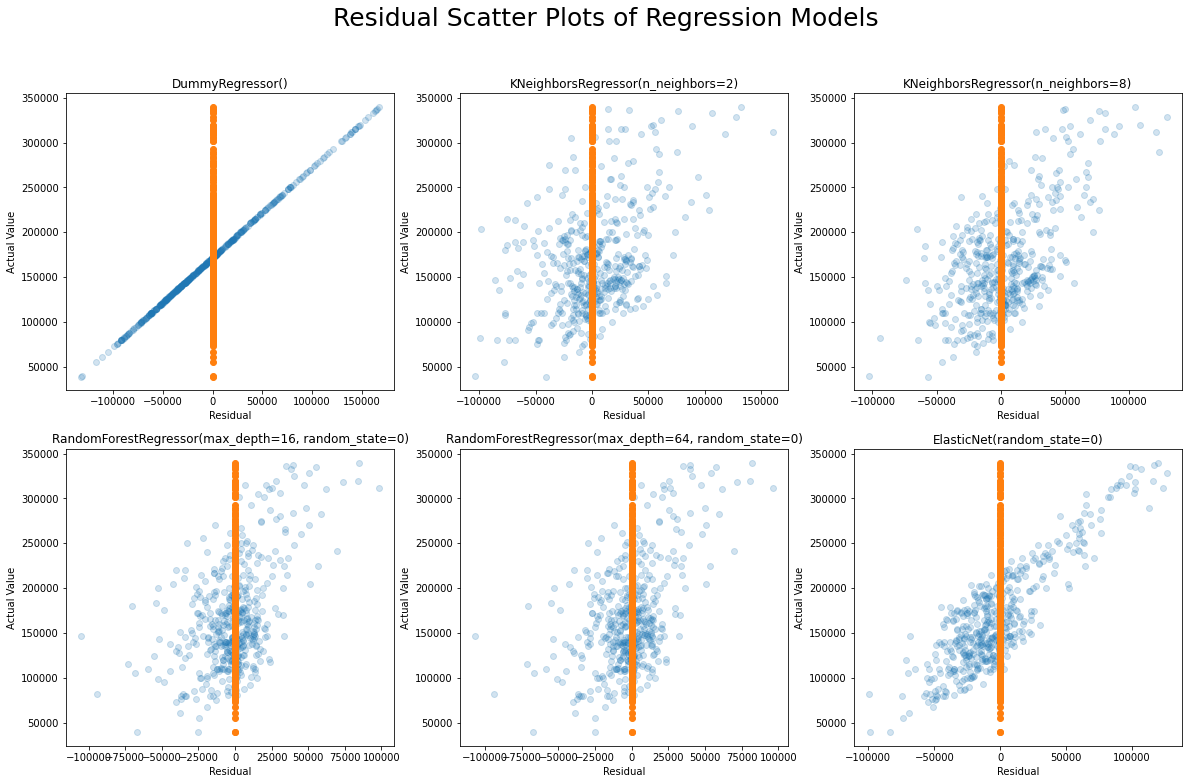

In [10]:
fig, ax = plt.subplots(2,3,figsize=(20,12))
fig.suptitle('Residual Scatter Plots of Regression Models',fontsize=25)
mods=list(residuals.keys())
count=0
for i in range(2):
    for j in range(3):
        temp=mods[count]
        ax[i][j].set_title(temp)
        ax[i][j].set_xlabel('Residual')
        ax[i][j].set_ylabel('Actual Value')
        ax[i][j].scatter(residuals[temp],y_test,alpha=0.2)
        ax[i][j].scatter([0 for i in y_test],y_test)
        count+=1

In the graphs above, I plot the predicted sale prices agaisnt the error of the prediction. This helps us see any patterns in the error that our models make. Just like before, the goal is for the blue points to be as close to the orange points as possible. Based on these graphs, all the models seem to under estimate the price of higher price homes. This presents an opportunity for more exploration and feature engineering

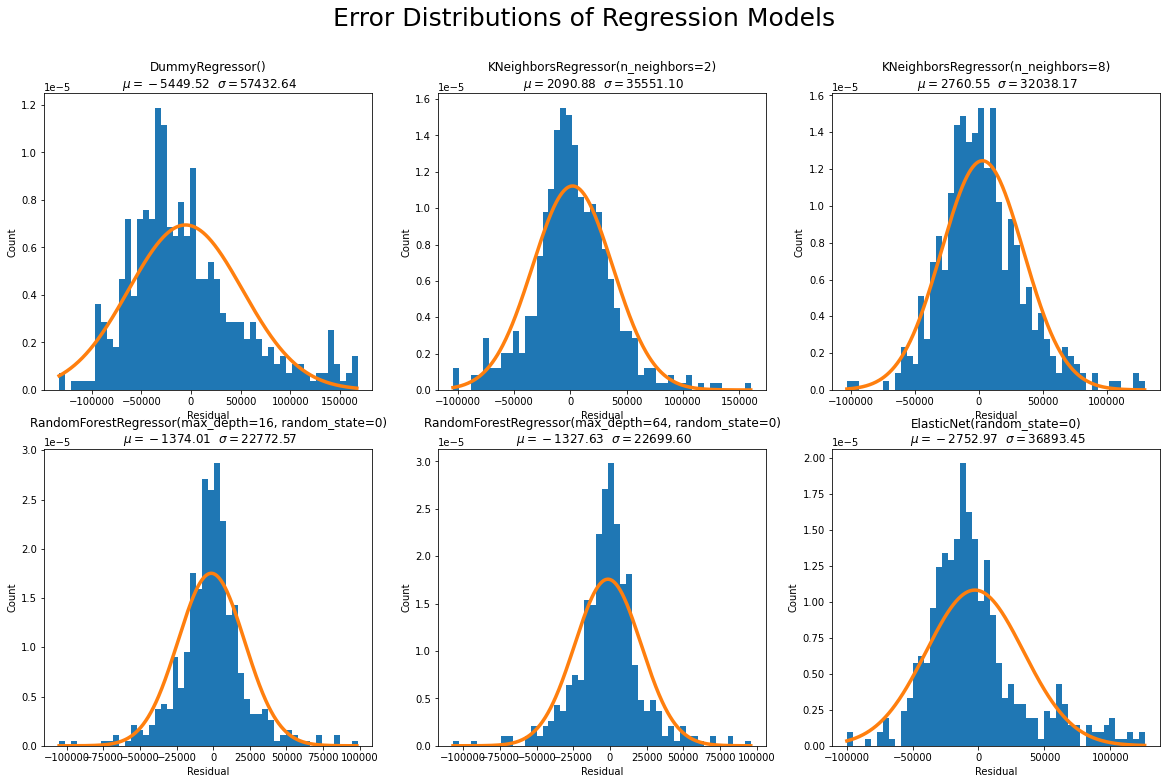

In [11]:
fig, ax = plt.subplots(2,3,figsize=(20,12))
fig.suptitle('Error Distributions of Regression Models',fontsize=25)
from scipy.stats import norm
import statistics

count=0
for i in range(2):
    for j in range(3):
        temp=mods[count]
        ax[i][j].hist(residuals[temp],bins=50,density=True)
        x_axis = np.arange(residuals[temp].min(), residuals[temp].max(), 
                           (residuals[temp].max()-residuals[temp].min())/len(residuals[temp]))
        mean = residuals[temp].mean()
        sd = residuals[temp].std()
        ax[i][j].set_xlabel('Residual')
        ax[i][j].set_ylabel('Count')
        ax[i][j].plot(x_axis, norm.pdf(x_axis, mean, sd),linewidth=3.5)
        ax[i][j].set_title(temp+ '\n'+r' $\mu=%.2f$' % (mean, )+r'  $\sigma=%.2f$' % (sd, ))
        count+=1

In the graphs above, I plot the error distribution for each model. Above each histogram, I plot a normal distribution with the same mean and standard deviastion as the errors for comparison. These graphs also help us see any patterns in the errors that our models make. The goal is for the distributions to be normal with a mean and standard deviation as close to zero as possible. Based on the graphs above, I can now rule out both of the KNN models because their error distributions aren't normal. 

From my analysis of the models, I know that one of the 2 random forest models will be the best model but I'm not sure which. I will have to use formal performance metrics to make that decision.

<p style="font-size:20px">Model Selection</p>
<p>In my model analysis, I wanted to look at model performance to get a better sense of how the models behaved so that I could see where to improve and what models to develop further. I was able to get a general sense of what models worked well but I still don't know which model was the best and how well it did. For that, I will use the R^2,the coefficient of determination. This metric will show the percentage of the home sale price variation the model can explain. This metric can reach a maximum of 1 which indicates perfect prediction so we want the model that is as close to that limit as possible.</p>

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
scores=[]
mses=[]
for model in mods:
    scores.append(r2_score(y_test,predictions[model]))
    mses.append(mse(y_test,predictions[model]))
mods=[i if 'Voting' not in i else 'VotingClassifer()' for i in mods]
temp=pd.DataFrame(mods, columns=['Models'])
temp['Scores']=scores
temp['M.S.E.']=mses
temp=temp.sort_values('Scores')

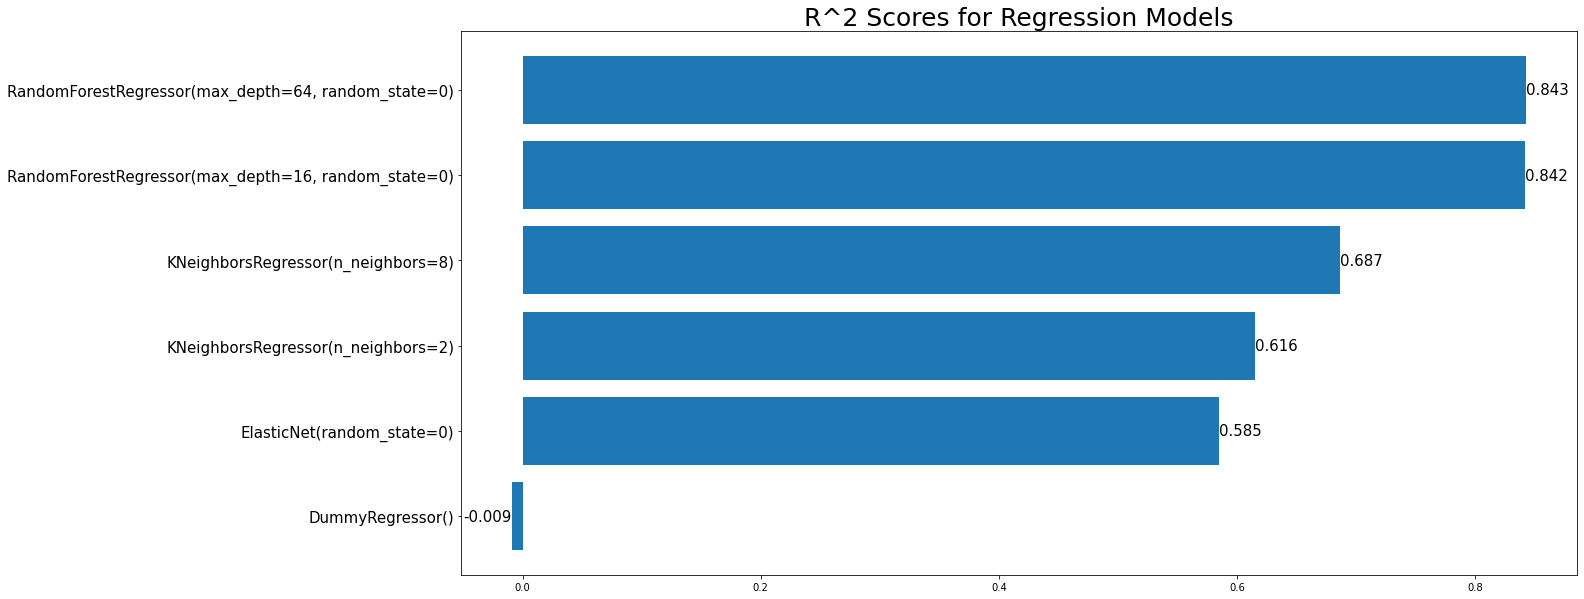

In [13]:
label = temp['Models']
y_pos = np.arange(len(label))
data = temp['Scores']

fig, ax = plt.subplots(figsize=(20,10))

hbars = ax.barh(y_pos, data,align='center')
ax.set_yticks(y_pos, labels=label,fontsize=15)
ax.set_title('R^2 Scores for Regression Models',fontsize=25)

ax.bar_label(hbars, fmt='%.3f',fontsize=15)

plt.show()

Looking at the performance of the models, both of the random forest models performed the best. Of these two models, I would use the second best option because it performs almost as well as the best model while using 1/4 of its computational resources. Considering that difference in the R^2 score is only 0.001, this tradeoff is worth it.

<p style="font-size:20px">Feature Analysis</p>
Now that I have the best model selected, I want to study how it uses the input features so that I have a sense of what is most important variable for predicting a house's value.

In [14]:
temp=models[-3].feature_importances_
temp=pd.DataFrame(temp).T
temp.columns=X.columns
temp=temp.T
temp.columns=['Importance']
temp=temp.sort_values('Importance', ascending=False)

<BarContainer object of 10 artists>

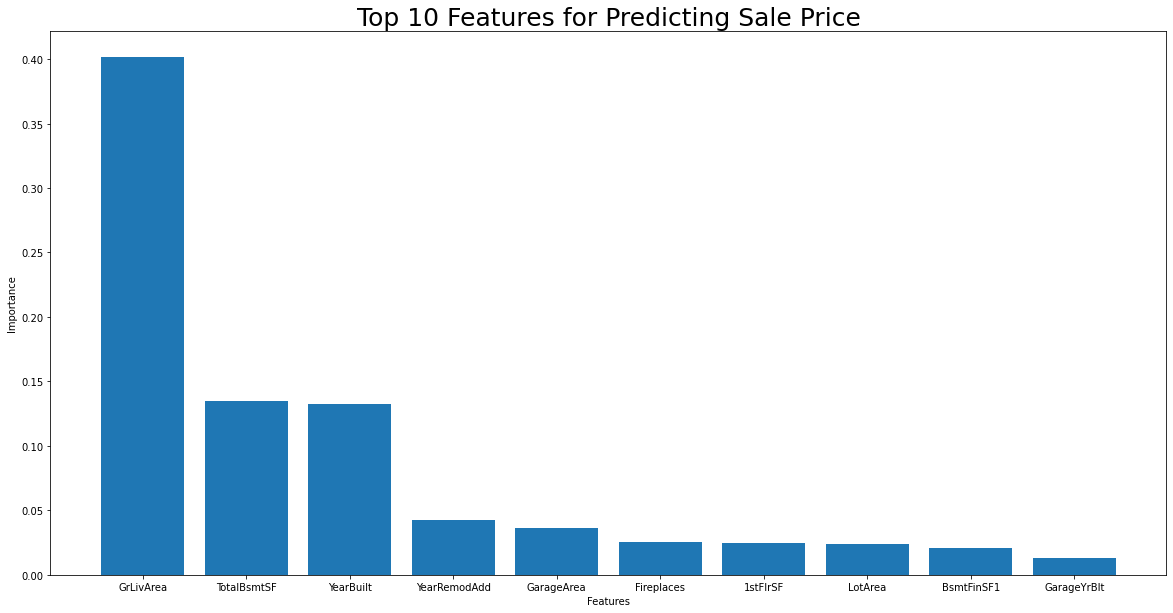

In [15]:
plt.figure(figsize=(20,10))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Features for Predicting Sale Price',fontsize=25)
plt.bar(temp.index[:10],temp['Importance'][:10])

Looking at the 10 best features for predicting home price, it is not suprising to see that most of them are related to some spatial or temporal aspect of the house. We noticed the strong relationship bewtween these types of variables and home price when we explored the data. Based on these findings, we can say that large newly built houses sell for more than smaller older houses.